# FLUX.1 Fill Pipeline
本notebook用于运行FLUX.1-Fill-dev图像修复模型

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import json
import torch
import numpy as np
from PIL import Image, ImageChops
from diffusers import FluxFillPipeline


MAX_SEED = np.iinfo(np.int32).max

def calculate_optimal_dimensions(image: Image.Image):
    original_width, original_height = image.size
    MIN_ASPECT_RATIO = 9 / 16
    MAX_ASPECT_RATIO = 16 / 9
    FIXED_DIMENSION = 1024

    original_aspect_ratio = original_width / original_height

    if original_aspect_ratio > 1:
        width = FIXED_DIMENSION
        height = round(FIXED_DIMENSION / original_aspect_ratio)
    else:
        height = FIXED_DIMENSION
        width = round(FIXED_DIMENSION * original_aspect_ratio)

    width = (width // 8) * 8
    height = (height // 8) * 8

    calculated_aspect_ratio = width / height
    if calculated_aspect_ratio > MAX_ASPECT_RATIO:
        width = (height * MAX_ASPECT_RATIO // 8) * 8
    elif calculated_aspect_ratio < MIN_ASPECT_RATIO:
        height = (width / MIN_ASPECT_RATIO // 8) * 8

    width = max(width, 576) if width == FIXED_DIMENSION else width
    height = max(height, 576) if height == FIXED_DIMENSION else height

    return width, height

def load_edit_sessions(json_path):
    """Load edit sessions from JSON file"""
    with open(json_path, 'r') as f:
        return json.load(f)

print("✓ 函数已加载")

✓ 函数已加载


## 1. 加载模型

In [2]:
# 配置参数
device = "cuda"  # 或 "cuda:0"

# 加载模型
print(f"Loading model to {device}...")
pipe = FluxFillPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-Fill-dev", 
    torch_dtype=torch.bfloat16
).to(device)
print("✓ 模型加载完成")

Loading model to cuda...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


✓ 模型加载完成


## 2. 加载图片并进行推理

In [14]:
# 选择session ID和编辑索引
session_id = "227117"  # 修改为你要处理的session ID
edit_index = 0  # 第几个编辑步骤（从0开始）

Session: 227117, Edit: 0
Input: test/images/227117/227117-input.png
Mask: test/images/227117/227117-mask1.png
Prompt: Put a bottle of wine on the counter.

Loading images...
Resizing to 1024x1024
Mask Stats - Size: (1024, 1024), Edit Pixels: 24881 (2.37%)
Running inference...


  0%|          | 0/50 [00:00<?, ?it/s]


Saving result to flux_results/227117_edit0.png


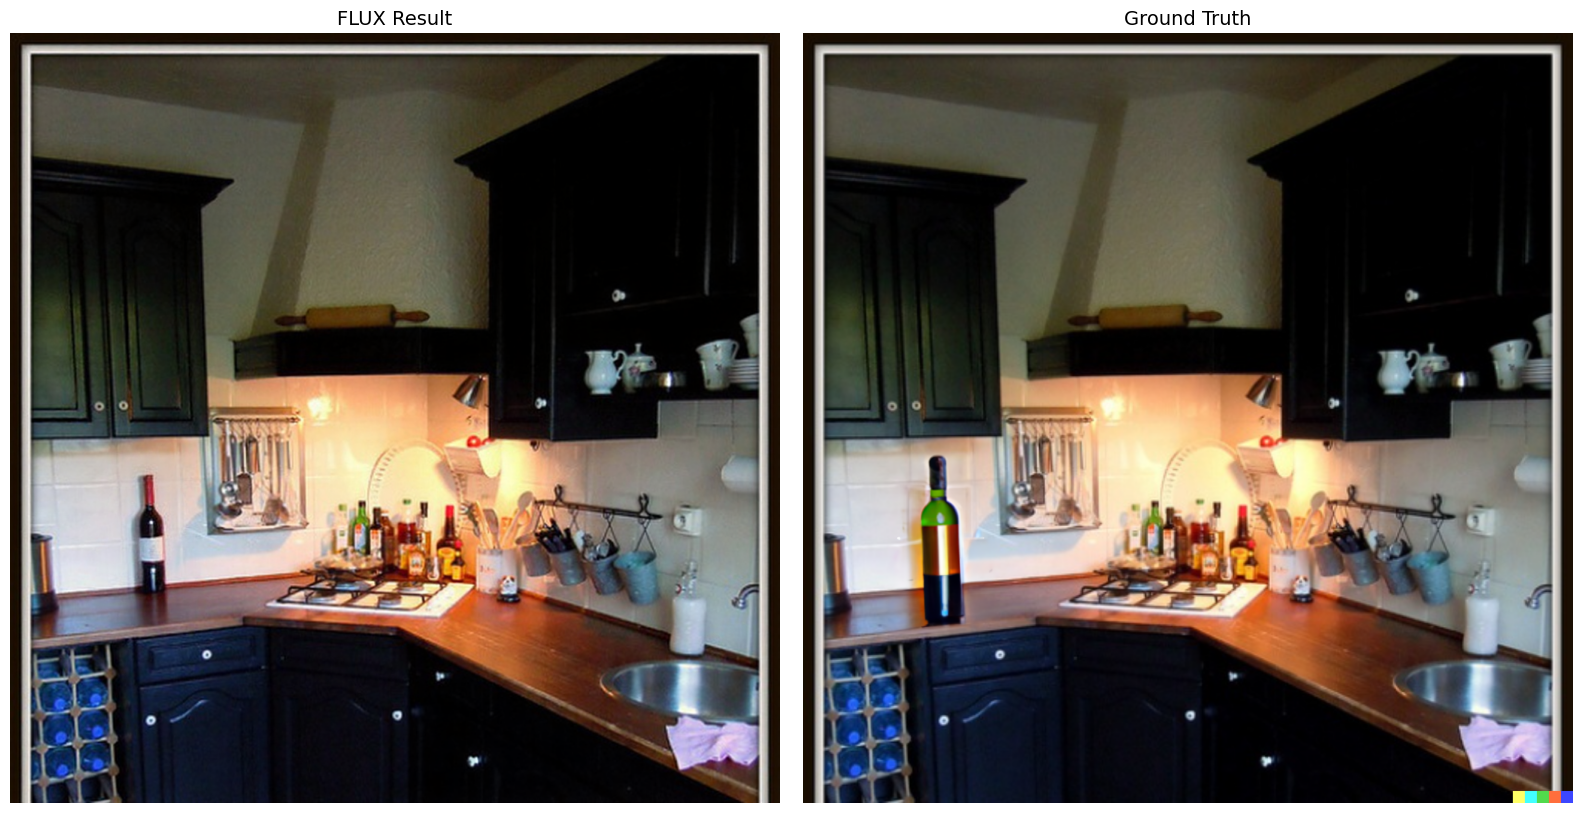

In [15]:
import matplotlib.pyplot as plt
# 从JSON配置文件读取
json_path = "test/edit_sessions.json"
images_base_dir = "test/images"

# 加载配置
edit_sessions = load_edit_sessions(json_path)



# 获取编辑任务
if session_id not in edit_sessions:
    raise ValueError(f"Session {session_id} not found in JSON")

edit_task = edit_sessions[session_id][edit_index]

# 构建图片路径
image_path = os.path.join(images_base_dir, session_id, edit_task["input"])
mask_path = os.path.join(images_base_dir, session_id, edit_task["mask"])
output_path = os.path.join("flux_results", f"{session_id}_edit{edit_index}.png")
gt_path = os.path.join(images_base_dir, session_id, edit_task["output"])
prompt = edit_task["instruction"]

print(f"Session: {session_id}, Edit: {edit_index}")
print(f"Input: {image_path}")
print(f"Mask: {mask_path}")
print(f"Prompt: {prompt}")

# 推理参数
seed = 0
guidance_scale = 3.5
steps = 50

# 加载图片
print(f"\nLoading images...")
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found: {image_path}")
if not os.path.exists(mask_path):
    raise FileNotFoundError(f"Mask not found: {mask_path}")

image = Image.open(image_path).convert("RGB")
input_mask = Image.open(mask_path)

# 加载GT图片（如果存在）
gt = None
if os.path.exists(gt_path):
    gt = Image.open(gt_path).convert("RGB")

# 计算最优尺寸
width, height = calculate_optimal_dimensions(image)
print(f"Resizing to {width}x{height}")
image = image.resize((width, height), Image.LANCZOS)

# 处理mask
final_mask = Image.new("L", (width, height), 0)

if input_mask.mode in ('RGBA', 'LA') or (input_mask.mode == 'P' and 'transparency' in input_mask.info):
    alpha = input_mask.convert('RGBA').split()[-1]
    if alpha.getextrema() != (255, 255):
        # Alpha < 255 (Transparent) -> Edit (White in mask)
        m = alpha.point(lambda p: 255 if p < 255 else 0).resize((width, height), Image.NEAREST)
        final_mask = ImageChops.lighter(final_mask, m)
    else:
        m = input_mask.convert("L").resize((width, height), Image.NEAREST)
        final_mask = ImageChops.lighter(final_mask, m)
else:
    m = input_mask.convert("L").resize((width, height), Image.NEAREST)
    final_mask = ImageChops.lighter(final_mask, m)

# 调试信息
fm_arr = np.array(final_mask)
white_px = np.sum(fm_arr > 128)
total_px = fm_arr.size
print(f"Mask Stats - Size: {final_mask.size}, Edit Pixels: {white_px} ({white_px/total_px:.2%})")

# 执行推理
print("Running inference...")
result_image = pipe(
    prompt=prompt,
    image=image,
    mask_image=final_mask,
    height=height,
    width=width,
    guidance_scale=guidance_scale,
    num_inference_steps=steps,
    generator=torch.Generator(device).manual_seed(seed)
).images[0]

# 保存结果
print(f"\nSaving result to {output_path}")
os.makedirs(os.path.dirname(output_path), exist_ok=True)
result_image.save(output_path)

# 并排显示结果
if gt is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(result_image)
    axes[0].set_title('FLUX Result', fontsize=14)
    axes[0].axis('off')
    axes[1].imshow(gt)
    axes[1].set_title('Ground Truth', fontsize=14)
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()
else:
    display(result_image)